# Trabalhando com dados do TSE



In [1]:
import requests
import zipfile
import io
import pandas
import logging
import os
import re

from slugify import slugify
from datetime import datetime, timedelta

## Baixando dados



In [2]:
class TSE_download():
    
    url = 'http://agencia.tse.jus.br/estatistica/sead/odsele/'
    folder_save = None
    
    @classmethod
    def download(cls, path='', **kwargs):
        this_url = os.path.join(cls.url, path)
        req = requests.get(this_url)
        try:
            zipped = zipfile.ZipFile(io.BytesIO(req.content))
            logging.info(f'Done')
        except zipfile.BadZipFile:
            logging.error(f'Not a valid file')
            return None
        if kwargs.get('save_local', False):
            for name in zipped.namelist():
                folder = cls.folder_save
                if not os.path.isdir(folder):
                    os.makedirs(folder)
                save_name = os.path.join(folder, name)
                with open(save_name, 'wb') as flsave:
                    with zipped.open(name) as flread:
                        flsave.write(flread.read())
        else:
            files = {}
            for name in zipped.namelist():
                with zipped.open(name) as flread:
                    files[name] = flread.read()
            return files

    @classmethod
    def read_files(cls, file_dict, header=0):
        dataframes = {}
        for name, fl in file_dict.items():
            if name.endswith('.csv') or name.endswith('txt'):
                dataframes['.'.join(name.split('.')[:-1])] = pandas.read_csv(
                    io.BytesIO(fl),
                    sep=';',
                    header=header,
                    encoding='latin1',
                )
        return dataframes

class TSE_download_demografia_zona(TSE_download):
    @classmethod
    def download(cls, ano, **kwargs):
        path = f'perfil_eleitorado/perfil_eleitorado_{ano}.zip'
        return super().download(path, **kwargs)

class TSE_download_demografia_secao(TSE_download):
    @classmethod
    def download(cls, ano, estado, **kwargs):
        path = f'perfil_eleitor_secao/perfil_eleitor_secao_{ano}_{estado}.zip'
        return super().download(path, **kwargs)
    
class TSE_download_candidatos(TSE_download):
    @classmethod
    def download(cls, ano, **kwargs):
        path = f'consulta_cand/consulta_cand_{ano}.zip'
        return super().download(path, **kwargs)
    
class TSE_download_votacao_candidato_zona(TSE_download):
    @classmethod
    def download(cls, ano, **kwargs):
        path = f'votacao_candidato_munzona/votacao_candidato_munzona_{ano}.zip'
        return super().download(path, **kwargs)
    
class TSE_download_votacao_partido_zona(TSE_download):
    @classmethod
    def download(cls, ano, **kwargs):
        path = f'votacao_partido_munzona/votacao_partido_munzona_{ano}.zip'
        return super().download(path, **kwargs)
    
class TSE_download_votacao_secao(TSE_download):
    @classmethod
    def download(cls, ano, estado, **kwargs):
        path = f'votacao_secao/votacao_secao_{ano}_{estado}.zip'
        return super().download(path, **kwargs)

class TSE_download_votacao_detalhezona(TSE_download):
    @classmethod
    def download(cls, ano, **kwargs):
        path = f'detalhe_votacao_munzona/detalhe_votacao_munzona_{ano}.zip'
        return super().download(path, **kwargs)

class TSE_download_votacao_detalhesecao(TSE_download):
    @classmethod
    def download(cls, ano, **kwargs):
        path = f'detalhe_votacao_secao/detalhe_votacao_secao_{ano}.zip'
        return super().download(path, **kwargs)

## Parseando dados de demografia

In [3]:
class TSE_parse_demografia:

    tabelas_dicionario = {
        'Gênero': {
            2: 'Masculino',
            4: 'Feminino',
        },
        'Escolaridade': {
            1: 'Analfabeto',
            2: 'Alfabetizado',
            3: 'Fundamental incompleto',
            4: 'Fundamental completo',
            5: 'Médio incompleto',
            6: 'Médio completo',
            7: 'Superior incompleto',
            8: 'Superior completo',
        },
        'EstadoCivil': {
            1: 'Solteiro',
            3: 'Casado',
            5: 'Viúvo',
            7: 'Separado',
            9: 'Divorciado',
        },
        'FaixaEtária': {
            '100-': '100-',
            '16-16': '16-16',
            '17-17': '17-17',
            '18-20': '18-20',
            '18-18': '18-18',
            '19-19': '19-19',
            '20-20': '20-20',
            '21-24': '21-24',
            '25-29': '25-29',
            '25-34': '25-34',
            '30-34': '30-34',
            '35-39': '35-39',
            '35-44': '35-44',
            '40-44': '40-44',
            '45-49': '45-49',
            '45-59': '45-59',
            '50-54': '50-54',
            '55-59': '55-59',
            '60-64': '60-64',
            '60-69': '60-69',
            '65-69': '65-69',
            '70-74': '70-74',
            '70-79': '70-79',
            '75-79': '75-79',
            '80-84': '80-84',
            '85-89': '85-89',
            '90-94': '90-94',
            '95-99': '95-99',
            '79-': '79-',   
        }
    }
    
    tabelas_depara = {
        'Gênero' : {
            'feminino': 4,
            'masculino': 2,
        },
        'Escolaridade' : {
            'analfabeto': 1,
            'ensino-fundamental-completo': 4,
            'ensino-fundamental-incompleto': 3, 
            'ensino-medio-completo': 6,
            'ensino-medio-incompleto': 5,
            'le-e-escreve': 2,
            'primeiro-grau-completo': 4,
            'primeiro-grau-incompleto': 3, 
            'segundo-grau-completo': 6,
            'segundo-grau-incompleto': 5,
            'superior-completo': 8,
            'superior-incompleto': 7,
        },
        'EstadoCivil' : {
            'casado': 3,
            'divorciado': 9,
            'separado-judicialmente': 7,
            'solteiro': 1,
            'viuvo': 5,
        },
        'FaixaEtária' : {
            '100-anos-ou-mais': '100-',
            '16-anos': '16-16',
            '17-anos': '17-17',
            '18-a-20-anos': '18-20',
            '18-anos': '18-18',
            '19-anos': '19-19',
            '20-anos': '20-20',
            '21-a-24-anos': '21-24',
            '25-a-29-anos': '25-29',
            '25-a-34-anos': '25-34',
            '30-a-34-anos': '30-34',
            '35-a-39-anos': '35-39',
            '35-a-44-anos': '35-44',
            '40-a-44-anos': '40-44',
            '45-a-49-anos': '45-49',
            '45-a-59-anos': '45-59',
            '50-a-54-anos': '50-54',
            '55-a-59-anos': '55-59',
            '60-a-64-anos': '60-64',
            '60-a-69-anos': '60-69',
            '65-a-69-anos': '65-69',
            '70-a-74-anos': '70-74',
            '70-a-79-anos': '70-79',
            '75-a-79-anos': '75-79',
            '80-a-84-anos': '80-84',
            '85-a-89-anos': '85-89',
            '90-a-94-anos': '90-94',
            '95-a-99-anos': '95-99',
            'superior-a-79-anos': '79-'
        },
    }
    
    @classmethod
    def list_municipios(cls, file_object, ano, nivel=None):
        if (str(ano) in ['2018', 'ATUAL']):
            columns = [
                ('SG_UF', 'UF'),
                ('CD_MUNICIPIO', 'Município'),
                ('NM_MUNICIPIO', 'Nome'),
            ]
            header = 0
        elif (str(ano) not in ['2018', 'ATUAL']) and (nivel == 'zona'):
            columns = [
                (1, 'UF'),
                (3, 'Município'),
                (2, 'Nome'),
            ]
            header = 0
        elif (str(ano) not in ['2018', 'ATUAL']) and (nivel == 'secao'):
            columns = [
                (3, 'UF'),
                (4, 'Município'),
                (5, 'Nome'),
            ]
            header = 0
        
        df = (
            pandas.read_csv(
                io.BytesIO(file_object),
                sep=';',
                header=header,
                encoding='latin1',
            )
            .rename(columns={x[0]: x[1] for x in columns})
            [[x[1] for x in columns]]
            .dropna()
            .drop_duplicates()
            
        )
        df['Município'] = df['Município'].apply(int)
        df = df.sort_values(by=['Município']).reset_index(drop=True)
        df['UF'] = df['UF'].apply(lambda x: str(x)[:2])
        df['slugified'] = df.apply(lambda x: "{}|{}".format(slugify(x['Nome']), slugify(x['UF'])), axis=1)
        return df

    @classmethod
    def parse(cls, file_object, ano, nivel):
        
        if (str(ano) in ['2018', 'ATUAL']) and (nivel == 'zona'):
            columns = [
                ('ANO_ELEICAO', 'Ano'),
                ('SG_UF', 'UF'),
                ('CD_MUNICIPIO', 'Município'),
                ('NR_ZONA', 'Zona'),
                ('DS_GENERO', 'Gênero'),
                ('DS_ESTADO_CIVIL', 'EstadoCivil'),
                ('DS_GRAU_ESCOLARIDADE', 'Escolaridade'),
                ('DS_FAIXA_ETARIA', 'FaixaEtária'),
                ('QT_ELEITORES_PERFIL', 'Quantidade'),
                ('QT_ELEITORES_DEFICIENCIA', 'QuantidadeDeficiência'),
                ('QT_ELEITORES_INC_NM_SOCIAL', 'QuantidadeNomeSocial'),
            ]
            columns_extra = []
            header = 0
        elif (str(ano) not in ['2018', 'ATUAL']) and (nivel == 'zona'):
            columns = [
                (0, 'Ano'),
                (1, 'UF'),
                (3, 'Município'),
                (4, 'Zona'),
                (5, 'Gênero'),
                (7, 'Escolaridade'),
                (6, 'FaixaEtária'),
                (8, 'Quantidade'),
            ]
            columns_extra = [
                'EstadoCivil',
                'QuantidadeDeficiência',
                'QuantidadeNomeSocial',
            ]
            header = None
        elif (str(ano) in ['2018', 'ATUAL']) and (nivel == 'secao'):
            columns = [
                ('ANO_ELEICAO', 'Ano'),
                ('SG_UF', 'UF'),
                ('CD_MUNICIPIO', 'Município'),
                ('NR_ZONA', 'Zona'),
                ('NR_SECAO', 'Seção'),
                ('DS_GENERO', 'Gênero'),
                ('DS_ESTADO_CIVIL', 'EstadoCivil'),
                ('DS_GRAU_ESCOLARIDADE', 'Escolaridade'),
                ('DS_FAIXA_ETARIA', 'FaixaEtária'),
                ('QT_ELEITORES_PERFIL', 'Quantidade'),
                ('QT_ELEITORES_DEFICIENCIA', 'QuantidadeDeficiência'),
                ('QT_ELEITORES_INC_NM_SOCIAL', 'QuantidadeNomeSocial'),
            ]
            columns_extra = []
            header = 0
        elif (str(ano) not in ['2018', 'ATUAL']) and (nivel == 'secao'):
            columns = [
                (2, 'Ano'),
                (3, 'UF'),
                (4, 'Município'),
                (6, 'Zona'),
                (7, 'Seção'),
                (9, 'EstadoCivil'),
                (15, 'Gênero'),
                (13, 'Escolaridade'),
                (11, 'FaixaEtária'),
                (16, 'Quantidade'),
            ]
            columns_extra = [
                'QuantidadeDeficiência',
                'QuantidadeNomeSocial',
            ]
            header = None
        
        df = (
            pandas.read_csv(
                io.BytesIO(file_object),
                sep=';',
                header=header,
                encoding='latin1',
            )
            .rename(columns={x[0]: x[1] for x in columns})
            [[x[1] for x in columns]]
            .reset_index(drop=True)
        )
        for col in columns_extra:
            df[col] = None
        
#         for col in ['Quantidade', 'QuantidadeDeficiência', 'QuantidadeNomeSocial']:
#             df[col] = df[col].fillna(0)
        
        for col, depara in cls.tabelas_depara.items():
            df[col] = df[col].apply(lambda x: depara.get(slugify(str(x).strip()), 0))

        df['Ano'] = df['Ano'].apply(lambda x: int(str(x)[:4]))
        df['UF'] = df['UF'].apply(lambda x: str(x)[:2])

#         categorical = ['UF', 'FaixaEtária']
#         for col in categorical:
#             if col in df.columns:
#                 df[col] = df[col].astype('category')
        
        return df
    
    @classmethod
    def get_dicionario(cls):
        return cls.tabelas_dicionario
    
    @classmethod
    def get_dicionario_pandas(cls):
        dfs = {}
        for key, value in cls.tabelas_dicionario.items():
            df = pandas.DataFrame(value.items())
            df.columns = [key, key+'_desc']
            dfs[key] = df
        return dfs
    

In [4]:
import re
def download_demografia_zona_all(anos=None):
    folder = os.path.expanduser('~/localdatalake/tse_refined/perfil')
    clsA = TSE_download_demografia_zona()
    clsB = TSE_parse_demografia()
    anos = anos or ['ATUAL']+list(range(2018, 1992, -2))
    output = {}
    exp = re.compile("perfil_eleitorado_([A-Za-z0-9]{4,}).([a-z]{3})")
    for ano in anos:
        download = clsA.download(ano)
        output[ano] = {
            x: clsB.parse(y, ano, 'zona')
            for x, y in download.items()
            if (x.endswith('txt') or x.endswith('csv'))
        }
        print(output[ano].keys())
        for name, df in output[ano].items():
            basename = os.path.basename(name)
            ano_s, extensao = exp.match(basename).groups()
            save = os.path.join(folder, 'PerfilZona_{}.csv'.format(ano_s))
            df.to_csv(save, index=False, header=True, sep=';', float_format='%.0f')
            print('Saved {}'.format(save))
        print(ano)
    return output

In [5]:
# a = download_demografia_zona_all(['ATUAL'])
# a = download_demografia_zona_all([2018,2016,2014,2012,2010,2008])
# a = download_demografia_zona_all([2006,2004,2002,2000,1998, 1996, 1994])

In [6]:
import re
ESTADOS_TODOS = [
    'BA', 'AL', 'SE', 'PE', 'RN', 'PB', 'CE', 'PI', 'MA',
    'PA', 'AM', 'AP', 'RO', 'RR', 'AC', 'TO',
    'GO', 'DF', 'MS', 'MT',
    'SP', 'MG', 'RJ', 'ES',
    'RS', 'SC', 'PR',
]
def download_demografia_secao_all(anos=None, estados=ESTADOS_TODOS):
    folder = os.path.expanduser('~/localdatalake/tse_refined/perfil')
    clsA = TSE_download_demografia_secao()
    clsB = TSE_parse_demografia()
    anos = anos or ['ATUAL']+list(range(2018, 1992, -2))
    output = {}
    exp = re.compile("perfil_eleitor_secao_([0-9A-Za-z]{4,})_([A-Z]{2}).([a-z]{3})")
    for ano in anos:
        for estado in estados:
            download = clsA.download(ano, estado)
            for x, y in download.items():
                if (x.endswith('txt') or x.endswith('csv')):
                    df = clsB.parse(y, ano, 'secao')
                    basename = os.path.basename(x)
                    ano_s, uf, extensao = exp.match(basename).groups()
                    save = os.path.join(folder, 'PerfilSecao_{}_{}.csv'.format(ano_s, uf))
                    df.to_csv(save, index=False, header=True, sep=';', float_format='%.0f')
                    print('Saved {}'.format(save))
            print(ano, estado)
    return output

In [7]:
# a = download_demografia_secao_all(anos=['ATUAL'])

## Parseando dados de candidatos

In [8]:
# anos = list(range(2018, 2000, -2))
# clsA = TSE_download_candidatos()
# basefolder = os.path.expanduser('~/localdatalake')
# for ano in anos:
#     downloads = clsA.download(ano)
#     for key, value in downloads.items():
#         if '_AC' in key:
#             filename = os.path.join(basefolder, 'tse_raw', key)
#             with open(filename, 'w') as f:
#                 f.write(value.decode('latin1'))
#             print("Saved {}".format(filename))
            

## Parseando dados de candidatos


In [9]:

class TSE_parse_candidatos:

    tabelas_dicionario = {
        'Gênero': {
            2: 'Masculino',
            4: 'Feminino',
        },
        'Escolaridade': {
            1: 'Analfabeto',
            2: 'Alfabetizado',
            3: 'Fundamental incompleto',
            4: 'Fundamental completo',
            5: 'Médio incompleto',
            6: 'Médio completo',
            7: 'Superior incompleto',
            8: 'Superior completo',
        },
        'EstadoCivil': {
            1: 'Solteiro',
            3: 'Casado',
            5: 'Viúvo',
            7: 'Separado',
            9: 'Divorciado',
        },
        'Cor': {
            1: 'Branca',
            2: 'Preta',
            3: 'Parda',
            4: 'Amarela',
            5: 'Indígena',
        },
        'Cargo' : {
            1: 'Presidente',
            2: 'Vice-Presidente',
            3: 'Governador',
            4: 'Vice-Governador',
            5: 'Senador',
            6: 'Deputado Federal',
            7: 'Deputado Estadual',
            8: 'Deputado Distrital',
            9: 'Suplente 1 de Senador',
            10: 'Suplente 2 de Senador',
            11: 'Prefeito',
            12: 'Vice-Prefeito',
            13: 'Vereador',
        }
    }
    
    tabelas_depara = {
        'Gênero' : {
            'feminino': 4,
            'masculino': 2,
        },
        'Escolaridade' : {
            'analfabeto': 1,
            'ensino-fundamental-completo': 4,
            'ensino-fundamental-incompleto': 3, 
            'ensino-medio-completo': 6,
            'ensino-medio-incompleto': 5,
            'le-e-escreve': 2,
            'primeiro-grau-completo': 4,
            'primeiro-grau-incompleto': 3, 
            'segundo-grau-completo': 6,
            'segundo-grau-incompleto': 5,
            'superior-completo': 8,
            'superior-incompleto': 7,
        },
        'EstadoCivil' : {
            'casado': 3,
            'divorciado': 9,
            'separado-judicialmente': 7,
            'solteiro': 1,
            'viuvo': 5,
            'casado-a': 3,
            'divorciado-a': 9,
            'separado-a-judicialmente': 7,
            'solteiro-a': 1,
            'viuvo-a': 5,
        },
        'Cor' : {
            'branca': 1,
            'preta': 2,
            'parda': 3,
            'amarela': 4,
            'indigena': 5,
        },
    }
    
    @classmethod
    def parse(cls, file_object, ano):
        
        if int(ano) >= 2014:
            columns = [
                ('ANO_ELEICAO', 'Ano'),
                ('NR_TURNO', 'Turno'),
                ('DS_ELEICAO', 'Eleição_nome'),
                ('DT_ELEICAO', 'Eleição_data'),
                ('SG_UF', 'UF'),
                ('SG_UE', 'UE'),
                ('CD_CARGO', 'Cargo'),
                ('SQ_CANDIDATO', 'id'),
                ('NR_CPF_CANDIDATO', 'Documento_CPF'),
                ('NM_CANDIDATO', 'Nome_completo'),
                ('NM_URNA_CANDIDATO', 'Urna_nome'),
                ('NM_SOCIAL_CANDIDATO', 'Nome_social'),
                ('NR_CANDIDATO', 'Urna_número'),
                ('DS_SITUACAO_CANDIDATURA', 'Situação'),
                ('DS_DETALHE_SITUACAO_CAND', 'Situação_detalhe'),
                ('TP_AGREMIACAO', 'Agremiação'),
                ('NR_PARTIDO', 'Partido_número'),
                ('SG_PARTIDO', 'Partido_sigla'),
                ('NM_PARTIDO', 'Partido_nome'),
                ('SQ_COLIGACAO', 'Coligação_código'),
                ('DS_COMPOSICAO_COLIGACAO', 'Coligação_composição'),
                ('DS_NACIONALIDADE', 'Nacionalidade'),
                ('NR_IDADE_DATA_POSSE', 'Idade'),
                ('SG_UF_NASCIMENTO', 'Nascimento_UF'),
                ('CD_MUNICIPIO_NASCIMENTO', 'Nascimento_município'),
                ('DT_NASCIMENTO', 'Nascimento_data'),
                ('DS_OCUPACAO', 'Ocupação'),
                ('NR_TITULO_ELEITORAL_CANDIDATO', 'Documento_título'),
                ('DS_GENERO', 'Gênero'),
                ('DS_GRAU_INSTRUCAO', 'Escolaridade'),
                ('DS_ESTADO_CIVIL', 'EstadoCivil'),
                ('DS_COR_RACA', 'Cor'),
                ('NR_DESPESA_MAX_CAMPANHA', 'Despesa'),
                ('DS_SIT_TOT_TURNO', 'Totalização'),
                ('ST_REELEICAO', 'Reeleição'),
                ('ST_DECLARAR_BENS', 'Declaração'),
            ]
            columns_extra = []
            header = 0
        elif ano <= 2012:
            columns = [
                (2, 'Ano'),
                (3, 'Turno'),
                (4, 'Eleição_nome'),
                (5, 'UF'),
                (6, 'UE'),
                (8, 'Cargo'),
                (11, 'id'),
                (13, 'Documento_CPF'),
                (10, 'Nome_completo'),
                (14, 'Urna_nome'),
                (12, 'Urna_número'),
                (16, 'Situação'),
                (17, 'Partido_número'),
                (18, 'Partido_sigla'),
                (19, 'Partido_nome'),
                (20, 'Coligação_código'),
                (22, 'Coligação_composição'),
                (36, 'Nacionalidade'),
                (28, 'Idade'),
                (37, 'Nascimento_UF'),
                (38, 'Nascimento_município'),
                (26, 'Nascimento_data'),
                (25, 'Ocupação'),
                (27, 'Documento_título'),
                (30, 'Gênero'),
                (32, 'Escolaridade'),
                (34, 'EstadoCivil'),
                (40, 'Despesa'),
                (42, 'Totalização'),
            ]
            columns_extra = [
                'Eleição_data',
                'Nome_social',
                'Situação_detalhe',
                'Agremiação',
                'Cor',
                'Reeleição',
                'Declaração',
            ]
            header = None

        df = (
            pandas.read_csv(
                io.BytesIO(file_object),
                sep=';',
                header=header,
                encoding='latin1',
                dtype='str',
            )
            .rename(columns={x[0]: x[1] for x in columns})
            [[x[1] for x in columns]]
            .reset_index(drop=True)
        )
        for col in columns_extra:
            df[col] = None
            
        for col, depara in cls.tabelas_depara.items():
            df[col] = df[col].apply(lambda x: depara.get(slugify(str(x).strip()), 0)).astype(int)
            
        for col in df.select_dtypes(include=['object']).columns:
            flter = df[col].apply(lambda x: x in ['#NULO#','#NE#'])
            if sum(flter)>0:
                df.loc[flter, col] = None
        
        for col in ['Nascimento_data', 'Eleição_data']:
            df[col] = df[col].apply(cls.parse_data)
        
        categorical = [
            'Eleição_nome',
#             'Eleição_data',
            'UF',
            'UE',
            'Partido_sigla',
            'Partido_nome',
            'Situação',
            'Situação_detalhe',
            'Agremiação',
            'Nacionalidade',
            'Nascimento_UF',
            'Totalização',
            'Reeleição',
            'Declaração',
        ]
        for col in categorical:
            if col in df.columns:
                df[col] = df[col].astype('category')
    
        numeric_integer = ['Ano', 'Turno', 'Cargo', 'Urna_número', 'Partido_número', 'Idade', 'Nascimento_município']
        numeric_float = ['Despesa']
        for col in numeric_integer:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: cls.parse_integer(x)).astype(int)
        for col in numeric_float:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: cls.parse_float(x)).astype(float)
                df.loc[df[col]<0, col] = None
    
        return df

    @staticmethod
    def parse_data(text):
        try:
            return datetime.strptime(text, '%d/%m/%Y').date()
        except (TypeError, ValueError):
            return None

    @staticmethod
    def parse_integer(text):
        try:
            return int(text)
        except (TypeError, ValueError):
            return -1

    @staticmethod
    def parse_float(text):
        try:
            return float(text)
        except (TypeError, ValueError):
            return None

In [10]:
def download_candidatos(anos=None):
    folder = os.path.expanduser('~/localdatalake/tse_refined/candidatos')
    clsA = TSE_download_candidatos()
    clsB = TSE_parse_candidatos()
    anos = anos or list(range(2018, 2002, -2))
    output = {}
    exp = re.compile("consulta_cand_([0-9]{4})_([A-Z]{2}).([a-z]{3})")
    for ano in anos:
        download = clsA.download(ano)
        output[ano] = {
            x: clsB.parse(y, ano)
            for x, y in download.items()
            if (x.endswith('txt') or x.endswith('csv')) and ('brasil' not in x.lower())
        }
        for name, df in output[ano].items():
            basename = os.path.basename(name)
            ano, uf, extensao = exp.match(basename).groups()
            save = os.path.join(folder, 'Candidatos_{}_{}.csv'.format(ano, uf))
            df.to_csv(save, index=False, header=True, sep=';', float_format='%.0f')
            print('Saved {}'.format(save))
        print(ano)
    return output

## Resultados da votação

In [11]:
# anos = list(range(2018, 2000, -2))
# clsA = TSE_download_votacao_candidato_zona()
# basefolder = os.path.expanduser('~/localdatalake')
# for ano in anos:
#     downloads = clsA.download(ano)
#     print(downloads.keys())
#     for key, value in downloads.items():
#         if '_AC' in key:
#             filename = os.path.join(basefolder, 'tse_raw', key)
#             with open(filename, 'w') as f:
#                 f.write(value.decode('latin1'))
#             print("Saved {}".format(filename))
            

In [12]:
class TSE_parse_votacao_partido_zona:

    @classmethod
    def parse(cls, file_object, ano):
        
        if int(ano) >= 2016:
            columns = [
                ('ANO_ELEICAO', 'Ano'),
                ('NR_TURNO', 'Turno'),
                ('DS_ELEICAO', 'Eleição_nome'),
                ('DT_ELEICAO', 'Eleição_data'),
                ('SG_UF', 'UF'),
                ('SG_UE', 'UE'),
                ('CD_CARGO', 'Cargo'),
                ('CD_MUNICIPIO', 'Município'),
                ('NR_ZONA', 'Zona'),
                ('TP_AGREMIACAO', 'Agremiação'),
                ('NR_PARTIDO', 'Partido_número'),
                ('SG_PARTIDO', 'Partido_sigla'),
                ('SQ_COLIGACAO', 'Coligação_código'),
                ('DS_COMPOSICAO_COLIGACAO', 'Coligação_composição'),
                ('ST_VOTO_EM_TRANSITO', 'Situação_trânsito'),
                ('QT_VOTOS_NOMINAIS', 'Votos_nominais'),
                ('QT_VOTOS_LEGENDA', 'Votos_legenda'),
            ]
            columns_extra = []
            header = 0
        elif ano <= 2014:
            columns = [
                (2, 'Ano'),
                (3, 'Turno'),
                (4, 'Eleição_nome'),
#                 ('DT_ELEICAO', 'Eleição_data'),
                (5, 'UF'),
                (6, 'UE'),
                (10, 'Cargo'),
                (7, 'Município'),
                (9, 'Zona'),
                (12, 'Agremiação'),
                (16, 'Partido_número'),
                (15, 'Partido_sigla'),
                (21 if ano==2014 else 20, 'Coligação_código'),
                (14, 'Coligação_composição'),
#                 ('ST_VOTO_EM_TRANSITO', 'Situação_trânsito'),
                (18, 'Votos_nominais'),
                (19, 'Votos_legenda'),
            ]
            columns_extra = [
                'Eleição_data',
            ]
            if ano==2014:
                columns += [(20, 'Situação_trânsito')]
            else:
                columns_extra += ['Situação_trânsito']
            header = None

        df = (
            pandas.read_csv(
                io.BytesIO(file_object),
                sep=';',
                header=header,
                encoding='latin1',
                dtype='str',
            )
            .rename(columns={x[0]: x[1] for x in columns})
            [[x[1] for x in columns]]
            .reset_index(drop=True)
        )
        for col in columns_extra:
            df[col] = None
                        
        for col in df.select_dtypes(include=['object']).columns:
            flter = df[col].apply(lambda x: x in ['#NULO#','#NE#'])
            if sum(flter)>0:
                df.loc[flter, col] = None
        
        for col in ['Eleição_data']:
            df[col] = df[col].apply(cls.parse_data)
        
        categorical = ['Eleição_nome', 'Eleição_data', 'UF', 'UE', 'Situação_trânsito', 'Agremiação', 'Partido_sigla', 'Partido_nome']
        for col in categorical:
            if col in df.columns:
                df[col] = df[col].astype('category')
    
        numeric_integer = ['Ano', 'Turno', 'Cargo', 'Município', 'Zona', 'Partido_número', 'Votos_nominais', 'Votos_legenda']
        numeric_float = []
        for col in numeric_integer:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: cls.parse_integer(x)).astype(int)
        for col in numeric_float:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: cls.parse_float(x)).astype(float)
                df.loc[df[col]<0, col] = None
    
        return df

    @staticmethod
    def parse_data(text):
        try:
            return datetime.strptime(text, '%d/%m/%Y').date()
        except (TypeError, ValueError):
            return None

    @staticmethod
    def parse_integer(text):
        try:
            return int(text)
        except (TypeError, ValueError):
            return -1

    @staticmethod
    def parse_float(text):
        try:
            return float(text)
        except (TypeError, ValueError):
            return None

In [13]:
class TSE_parse_votacao_candidato:

    @classmethod
    def parse(cls, file_object, ano, nivel):
        
        if int(ano) >= 2016:
            columns = [
                ('ANO_ELEICAO', 'Ano'),
                ('NR_TURNO', 'Turno'),
                ('DS_ELEICAO', 'Eleição_nome'),
#                 ('DT_ELEICAO', 'Eleição_data'),
                ('SG_UF', 'UF'),
                ('SG_UE', 'UE'),
                ('CD_CARGO', 'Cargo'),
                ('CD_MUNICIPIO', 'Município'),
                ('NR_ZONA', 'Zona'),
                ('NR_VOTAVEL', 'Urna_número'),
                ('QT_VOTOS', 'Votos'),
            ]
            if nivel == 'secao':
                columns += [('NR_SECAO', 'Seção'),]
            columns_extra = []
            header = 0
        elif ano <= 2014:
            shift_secao = 1 if nivel == 'secao' else 0
            columns = [
                (2, 'Ano'),
                (3, 'Turno'),
                (4, 'Eleição_nome'),
                (5, 'UF'),
                (6, 'UE'),
                (10+shift_secao, 'Cargo'),
                (7, 'Município'),
                (9, 'Zona'),
                (12+shift_secao, 'Urna_número'),
                (13+shift_secao, 'Votos'),
            ]
            if nivel == 'secao':
                columns += [(10, 'Seção'),]
            columns_extra = []

        df = (
            pandas.read_csv(
                io.BytesIO(file_object),
                sep=';',
                header=header,
                encoding='latin1',
                dtype='str',
            )
            .rename(columns={x[0]: x[1] for x in columns})
            [[x[1] for x in columns]]
            .reset_index(drop=True)
        )
        for col in columns_extra:
            df[col] = None
                        
        for col in df.select_dtypes(include=['object']).columns:
            flter = df[col].apply(lambda x: x in ['#NULO#','#NE#'])
            if sum(flter)>0:
                df.loc[flter, col] = None
        
        
        categorical = ['Eleição_nome', 'UF', 'UE',]
        for col in categorical:
            if col in df.columns:
                df[col] = df[col].astype('category')
    
        numeric_integer = ['Ano', 'Turno', 'Cargo', 'Município', 'Zona', 'Seção', 'Votos', 'Urna_número']
        numeric_float = []
        for col in numeric_integer:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: cls.parse_integer(x)).astype(int)
        for col in numeric_float:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: cls.parse_float(x)).astype(float)
                df.loc[df[col]<0, col] = None
    
        return df

    @staticmethod
    def parse_data(text):
        try:
            return datetime.strptime(text, '%d/%m/%Y').date()
        except (TypeError, ValueError):
            return None

    @staticmethod
    def parse_integer(text):
        try:
            return int(text)
        except (TypeError, ValueError):
            return -1

    @staticmethod
    def parse_float(text):
        try:
            return float(text)
        except (TypeError, ValueError):
            return None

In [16]:
# def download_votacao_partido_zona(anos=None):
#     clsA = TSE_download_votacao_partido_zona()
#     clsB = TSE_parse_votacao_partido_zona()
#     anos = anos or list(range(2018, 2012, -2))
#     output = {}
#     try:
#         for ano in anos:
#             download = clsA.download(ano)
#             print(download.keys())
#             output[ano] = {
#                 x: clsB.parse(y, ano)
#                 for x, y in download.items()
#                 if (x.endswith('txt') or x.endswith('csv')) and ('brasil' not in x.lower())
#             }
#             print(ano)
#     except KeyboardInterrupt:
#         pass
#     return output

In [17]:
print(2)

2


In [18]:
def download_votacao_secao(anos=None, estados=None):
    clsA = TSE_download_votacao_secao()
    clsB = TSE_parse_votacao_candidato()
    anos = anos or list(range(2018, 2012, -2))
    output = {}
    try:
        for ano in anos:
            for estado in estados:
                download = clsA.download(ano, estado)
                print(download.keys())
                output[ano] = {
                    x: clsB.parse(y, ano, nivel='secao')
                    for x, y in download.items()
                    if (x.endswith('txt') or x.endswith('csv')) and ('brasil' not in x.lower())
                }
                print(ano, estado)
    except KeyboardInterrupt:
        pass
    return output

In [20]:
test = TSE_download_votacao_secao.download(2012,'AC')

ERROR:root:Not a valid file


In [26]:
t = download_votacao_secao([2018],['BR'])

dict_keys(['leiame.pdf', 'votacao_secao_2018_BR.csv'])
2018 BR


In [29]:
df = t[2018]['votacao_secao_2018_BR.csv']
df.head()

,Ano,Turno,Eleição_nome,UF,UE,Cargo,Município,Zona,Urna_número,Votos,Seção
0,2018,1,ELEIÇÃO GERAL FEDERAL 2018,RS,BR,1,87815,115,95,1,57
1,2018,2,ELEIÇÃO GERAL FEDERAL 2018,MA,BR,1,9458,73,17,32,7
2,2018,1,ELEIÇÃO GERAL FEDERAL 2018,MG,BR,1,49158,202,96,8,25
3,2018,1,ELEIÇÃO GERAL FEDERAL 2018,PA,BR,1,4154,72,51,8,5
4,2018,1,ELEIÇÃO GERAL FEDERAL 2018,RS,BR,1,88013,113,13,64,297


In [62]:
df['Eleição_nome'].value_counts()

ELEIÇÃO GERAL FEDERAL 2018    6616660
Name: Eleição_nome, dtype: int64

In [33]:
df.query('Turno==1')['Votos'].sum() / 1e6

117.364654

In [34]:
df.query('Turno==2')['Votos'].sum() / 1e6

115.933451

In [35]:
t2 = download_votacao_secao([2018],['AC'])
df2 = t2[2018]['votacao_secao_2018_AC.csv']

dict_keys(['votacao_secao_2018_AC.csv', 'leiame.pdf'])
2018 AC


In [36]:
df2.groupby('Cargo').count()

,Ano,Turno,Eleição_nome,UF,UE,Município,Zona,Urna_número,Votos,Seção
Cargo,,,,,,,,,,
3,11190,11190,11190,11190,11190,11190,11190,11190,11190,11190
5,15227,15227,15227,15227,15227,15227,15227,15227,15227,15227
6,82223,82223,82223,82223,82223,82223,82223,82223,82223,82223
7,151392,151392,151392,151392,151392,151392,151392,151392,151392,151392


In [63]:
df2['Eleição_nome'].value_counts()

ELEIÇÕES GERAIS ESTADUAIS 2018    260032
Name: Eleição_nome, dtype: int64

In [39]:
df2[(df2['Cargo']==6)&(df2['Urna_número']<100)].head()

,Ano,Turno,Eleição_nome,UF,UE,Cargo,Município,Zona,Urna_número,Votos,Seção
4,2018,1,ELEIÇÕES GERAIS ESTADUAIS 2018,AC,AC,6,1392,9,31,1,268
12,2018,1,ELEIÇÕES GERAIS ESTADUAIS 2018,AC,AC,6,1392,1,45,1,749
14,2018,1,ELEIÇÕES GERAIS ESTADUAIS 2018,AC,AC,6,1074,4,51,2,360
23,2018,1,ELEIÇÕES GERAIS ESTADUAIS 2018,AC,AC,6,1392,1,95,6,327
36,2018,1,ELEIÇÕES GERAIS ESTADUAIS 2018,AC,AC,6,1392,1,95,6,553


In [40]:
df2[(df2['Urna_número']>91)&(df2['Urna_número']<100)].count()

Ano             14632
Turno           14632
Eleição_nome    14632
UF              14632
UE              14632
Cargo           14632
Município       14632
Zona            14632
Urna_número     14632
Votos           14632
Seção           14632
dtype: int64

In [50]:
test = df2.query('Turno==1').groupby(['UF','Zona','Seção','Cargo'], as_index=True).agg({'Votos': 'sum'})

In [53]:
test2 = test.reset_index().query('Cargo!=5').dropna().groupby(['UF','Zona','Seção']).agg({'Votos': 'nunique'})

In [55]:
test2['Votos'].value_counts()

1    1924
Name: Votos, dtype: int64

In [58]:
df2.query('Urna_número>90').query('Urna_número<100')['Urna_número'].value_counts()


96    7464
95    7168
Name: Urna_número, dtype: int64

In [61]:
tipo_voto = lambda x: 'Partido' if x<=90 else 'Pessoa' if x>=100 else 'Branco/nulo'
df2['Tipo'] = df2['Urna_número'].apply(tipo_voto)
df2.groupby(['Turno', 'Cargo', 'Tipo'])['Votos'].sum().head(20)

Turno  Cargo  Tipo       
1      3      Branco/nulo     26353
              Partido        417076
       5      Branco/nulo     91949
              Pessoa         794909
       6      Branco/nulo     18309
              Partido         26987
              Pessoa         398133
       7      Branco/nulo     14894
              Partido         29215
              Pessoa         399320
Name: Votos, dtype: int64

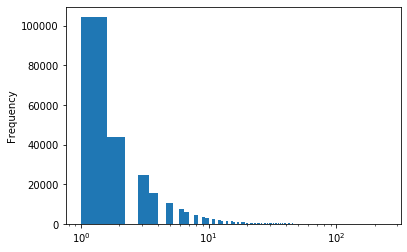

In [67]:
%matplotlib inline
df2['Votos'].plot.hist(bins=400, logx=True)

In [ ]:
c[2014]['votacao_partido_munzona_2014_SP.txt'].head(5).T

In [ ]:
c[2016]['votacao_partido_munzona_2016_SP.csv'].head(5).T

In [ ]:
c[2018]['votacao_partido_munzona_2018_BR.csv'].head(5).T

In [ ]:
c[2018]['votacao_partido_munzona_2018_SP.csv'].info()

In [ ]:
df = c[2018]['votacao_partido_munzona_2018_MG.csv'] 

In [ ]:
df.info()

In [ ]:
q = df.groupby([
    df['UF'].astype('object'), 'Turno','Cargo','Município','Zona', 'Partido_número'], as_index=False)['Ano'].count()

In [ ]:
q['Ano'].value_counts()

In [ ]:
q.info()

In [ ]:
ESTADOS_TODOS = [
    'RS', 'SC', 'PR',
    'SP', 'MG', 'RJ', 'ES',
    'BA', 'AL', 'SE', 'PE', 'RN', 'PB', 'CE', 'PI', 'MA',
    'PA', 'AM', 'AP', 'RO', 'RR', 'AC', 'TO',
    'GO', 'DF', 'MS', 'MT'
]
def download_votacao_secao(anos=None, estados=None):
    clsA = TSE_download_votacao_secao()
    clsB = TSE_parse_votacao_candidato()
    anos = anos or list(range(2018, 2012, -2))
    estados = estados or ESTADOS_TODOS + ['BR']
    output = {}
    try:
        for ano in anos:
            for estado in estados:
                download = clsA.download(ano, estado)
                print(download.keys())
                output[ano] = {
                    x: clsB.parse(y, ano, 'secao')
                    for x, y in download.items()
                    if (x.endswith('txt') or x.endswith('csv')) and ('brasil' not in x.lower())
                }
                print(ano, estado)
    except KeyboardInterrupt:
        pass
    return output

In [ ]:
q = download_votacao_secao(estados=['AC', 'RR'])

In [70]:
eval('None') or 12

12